# Neural Style Transfer - Pytorch 

## 1. Preparación y Carga de Imágenes
Primero, importamos las librerías y definimos las funciones para cargar imágenes.

In [1]:
# 1. Librerias 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 1.1 Configuración del dispositivo (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 2. AUMENTAR EL TAMAÑO DE LA IMAGEN 
# Aumento de los valores. Por ejemplo, 1024 si tienes GPU, o 512 si usas CPU.
# Nota: Si tu computadora se queda sin memoria, baja un poco estos números.
imsize = 1024 if torch.cuda.is_available() else 512

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_images_half_size(content_path, style_path):
    # 3. Cargamos la imagen de contenido para ver su tamaño original
    content_pil = Image.open(content_path).convert('RGB')
    original_width, original_height = content_pil.size
    
    # 4. Calculamos exactamente el 50% de las dimensiones
    new_width = int(original_width * 0.5)
    new_height = int(original_height * 0.5)
    print(f"Tamaño original: {original_width}x{original_height} -> Procesando al 50%: {new_width}x{new_height}")
    
    # 5. Creamos una transformación dinámica con el nuevo tamaño
    # Nota: transforms.Resize siempre pide la tupla en formato (Alto, Ancho)
    dynamic_transform = transforms.Compose([
        transforms.Resize((new_height, new_width)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 6. Aplicamos la transformación al contenido
    content_tensor = dynamic_transform(content_pil).unsqueeze(0).to(device, torch.float)
    
    # 5. Aplicamos la misma transformación al estilo para que coincidan perfectamente
    style_pil = Image.open(style_path).convert('RGB')
    style_tensor = dynamic_transform(style_pil).unsqueeze(0).to(device, torch.float)
    
    return content_tensor, style_tensor

# 7. Transformación inversa para poder visualizar la imagen resultante
unloader = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.ToPILImage()
])

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    
    plt.imshow(image)
    plt.axis('off') 
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Usando dispositivo: cuda


## 2. Definición de las Métricas (Losses)

Definimos funciones matemáticas simples o pequeños módulos. La fórmula general que optimizaremos será:

<div align="center">
    
</div>


In [3]:
def calc_content_loss(gen_features, content_features):
    return torch.mean((gen_features - content_features) ** 2)

def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    # 1. Producto punto del tensor por su transpuesta
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

def calc_style_loss(gen_features, style_features):
    G_gen = gram_matrix(gen_features)
    G_style = gram_matrix(style_features)
    return torch.mean((G_gen - G_style) ** 2)

def calc_tv_loss(img):
    # 2. Variación total para suavizar la imagen (reducir el ruido de píxeles)
    tv_h = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :]) ** 2)
    tv_w = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1]) ** 2)
    return tv_h + tv_w

## 3. Extracción de Rasgos (Modelo VGG16)
PyTorch nos permite acceder fácilmente a las capas internas de un modelo preentrenado. Mapeamos los índices de las capas de vgg16.features.

In [4]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Cargamos VGG16 preentrenado y congelamos sus pesos
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        for param in vgg.parameters():
            param.requires_grad = False
        
        self.model = vgg.to(device).eval()
        
        # 2. Índices de las capas 
        self.style_layers = {
            '0': 'block1_conv1',
            '5': 'block2_conv1',
            '10': 'block3_conv1',
            '19': 'block4_conv1',
            '28': 'block5_conv1'
        }
        self.content_layers = {'30': 'block5_conv2'}

    def forward(self, x):
        style_features = {}
        content_features = {}
        
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.style_layers:
                style_features[self.style_layers[name]] = x
            if name in self.content_layers:
                content_features[self.content_layers[name]] = x
                
        return content_features, style_features

## 4. Bucle de Optimización (L-BFGS)
Configuramos las imágenes, instanciamos el modelo y corremos el bucle. Usamos el optimizador L-BFGS, que requiere una función closure en PyTorch.

Tamaño original: 1600x1200 -> Procesando al 50%: 800x600
Iniciando la transferencia de estilo...
Iniciando iteración 1/10


C:\Users\i9_MGC\anaconda3\envs\pytorch-gpu\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())


Iniciando iteración 2/10
Iniciando iteración 3/10
Iniciando iteración 4/10
Iniciando iteración 5/10
Iniciando iteración 6/10
Iniciando iteración 7/10
Iniciando iteración 8/10
Iniciando iteración 9/10
Iniciando iteración 10/10
¡Proceso completado! Imagen guardada.


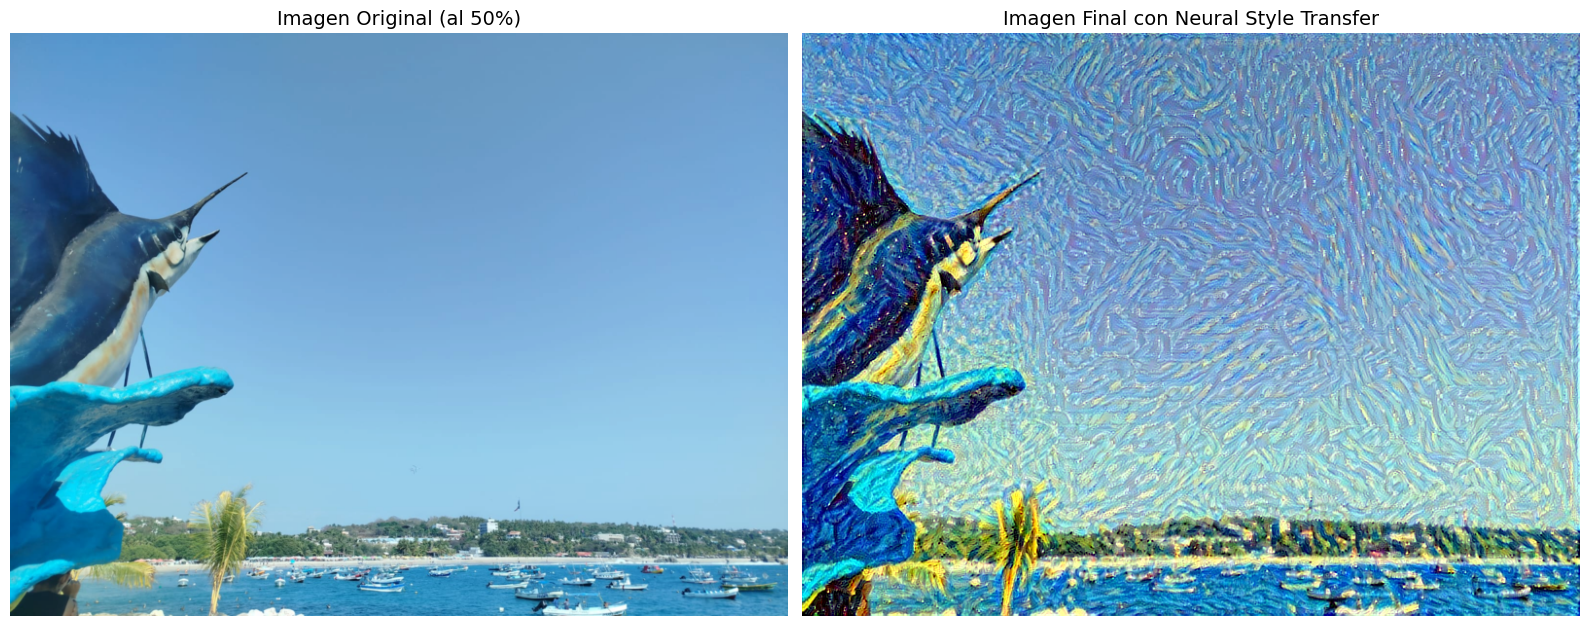

In [5]:
# 1. CONFIGURACIÓN DE RUTAS 
imgContent_path = 'mar.jpeg'
imgStyle_path = 'pin_2.jpg'

# 1.1 Cargar imágenes
content_img, style_img = load_images_half_size(imgContent_path, imgStyle_path)

# 1.2 Inicializamos la imagen generada clonando la de contenido (convergencia más rápida)
# y le indicamos a PyTorch que esta es la variable que vamos a optimizar
gen_img = content_img.clone().requires_grad_(True)

extractor = VGGFeatureExtractor()

# 1.3 Extraer los rasgos objetivo de las imágenes originales (solo se hace una vez)
target_content_features, _ = extractor(content_img)
_, target_style_features = extractor(style_img)

# 1.4 Pesos de las pérdidas (se ajustan para tener resultados a nuestra preferencia)
content_weight = 1.2
style_weight = 1e5
tv_weight = 1e-6

# 2. Optimizador L-BFGS
optimizer = optim.LBFGS([gen_img], max_iter=20)
iterations = 10

print("Iniciando la transferencia de estilo...")
for i in range(iterations):
    print(f'Iniciando iteración {i+1}/{iterations}')
    
    def closure():
        optimizer.zero_grad()
        # 2.1 Restringimos los valores de los píxeles, aproximación rápida para los límites de normalización
        gen_img.data.clamp_(-2.1, 2.6) 
        
        gen_content_features, gen_style_features = extractor(gen_img)
        
        # 3. Pérdida de Contenido
        c_loss = calc_content_loss(gen_content_features['block5_conv2'], 
                                   target_content_features['block5_conv2'])
        
        # 4. Pérdida de Estilo
        s_loss = 0
        for layer_name in target_style_features:
            s_loss += calc_style_loss(gen_style_features[layer_name], 
                                      target_style_features[layer_name])
        s_loss /= len(target_style_features)
        
        # 5. Pérdida de Variación Total
        t_loss = calc_tv_loss(gen_img)
        
        # 6. Pérdida Total
        total_loss = (content_weight * c_loss) + (style_weight * s_loss) + (tv_weight * t_loss)
        total_loss.backward()
        
        return total_loss

    optimizer.step(closure)

# 7.0 Limitar valores de la imagen final y guardar
gen_img.data.clamp_(-2.1, 2.6)
final_image = unloader(gen_img.cpu().squeeze(0))
final_image.save('cic_vangogh5_pytorch.jpg')

print("¡Proceso completado! Imagen guardada.")

fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 

axes[0].set_title('Imagen Original (al 50%)', fontsize=14)
img_original = unloader(content_img.cpu().squeeze(0))
axes[0].imshow(img_original)
axes[0].axis('off')
axes[1].set_title('Imagen Final con Neural Style Transfer', fontsize=14)
axes[1].imshow(final_image)
axes[1].axis('off')

plt.tight_layout() 
plt.show()